## Reference
- [00 ColaboratoryでChainerを動かしてみよう](https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/hands_on/chainer/begginers_hands_on/00_How_to_use_chainer_on_colaboratory.html)

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7900      0 --:--:-- --:--:-- --:--:--  7900
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
+ pip install -q cupy-cuda100  chainer 
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
+ set +ex
Installation succeeded!


In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.9.0-8-amd64-x86_64-with-debian-9.4
Chainer: 5.4.0
NumPy: 1.16.3
CuPy:
  CuPy Version          : 5.4.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: Not Available


In [3]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%ls ../input

dog-breed-identification/  resnet-50-caffe/


In [5]:
%ls ../input/resnet-50-caffe/

ResNet-50-model.caffemodel


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer
import cv2
import chainer.functions as F
import chainer.links as L
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from chainer import optimizers
from chainer import training

In [7]:
data_path = Path("../input/dog-breed-identification/")

In [8]:
labels = pd.read_csv(data_path.joinpath("labels.csv"))
submit = pd.read_csv(data_path.joinpath("sample_submission.csv"))

In [9]:
print("labels'shape : {}".format(labels.shape))
print("unique label : {}".format(len(labels["breed"].unique())))

labels'shape : (10222, 2)
unique label : 120


In [10]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


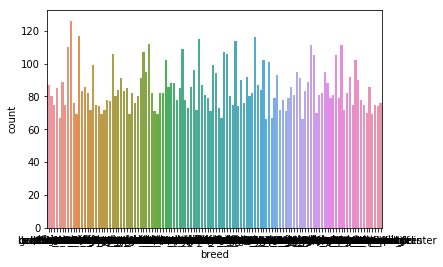

In [11]:
sns.countplot(data=labels, x="breed")

In [12]:
def load_img_shapes(path_to_img):
    return cv2.imread(path_to_img).shape

In [13]:
# reference
# https://www.kaggle.com/enerrio/data-exploration-distribution-of-image-sizes
def distribution_img_shapes(path):
    shapes = []
    for img_path in path.glob("*.jpg"):
        shapes.append(load_img_shapes(str(img_path)))
    df = pd.DataFrame({'Shapes': shapes})
    shape_counts = df['Shapes'].value_counts()
    print("Image Shapes:")
    for i in range(len(shape_counts)):
        print("Shape %s counts: %d" % (shape_counts.index[i],
                                       shape_counts.values[i]))

In [14]:
# distribution_img_shapes(data_path.joinpath("train"))

In [15]:
# distribution_img_shapes(data_path.joinpath("test"))

In [16]:
le = LabelEncoder()
labels["breed"] = le.fit_transform(labels["breed"])

In [17]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [18]:
# sample
labels.loc[labels["id"] == "000bec180eb18c7604dcecc8fe0dba07", "breed"]
labels.loc[labels["id"] == "000bec180eb18c7604dcecc8fe0dba07", "breed"].values[0]

19

In [19]:
train_image_files = []
for img_path in data_path.joinpath("train").glob("*.jpg"):
    label = labels.loc[labels["id"] == img_path.stem, "breed"].values[0]
    train_image_files.append((str(img_path), label.astype(np.int32)))

In [20]:
train_image_files[0]

('../input/dog-breed-identification/train/c7ac8dc219cb3bba12deee6e9778f5ba.jpg',
 118)

In [21]:
type(train_image_files[0][0]), type(train_image_files[0][1])

(str, numpy.int32)

In [22]:
seed = 42
epochs = 10
batch_size = 32
loaderjob = 4

In [23]:
train_dataset = chainer.datasets.LabeledImageDataset(train_image_files)

In [24]:
def _transform(data):
    img, label = data
    img = img[:3, ...]
    img = _resize(img.astype(np.uint8))
    img = img / 255.0
    img = img.astype(np.float32)
    return img, label

def _resize(img,width=224, height=224):
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    return np.asarray(img).transpose(2, 0, 1)

In [25]:
transform_train_dataset = chainer.datasets.TransformDataset(train_dataset, _transform)

In [26]:
train, val = chainer.datasets.split_dataset_random(transform_train_dataset, 9000, seed=seed)

In [27]:
len(train), len(val)

(9000, 1222)

In [28]:
train_iter = chainer.iterators.SerialIterator(train, batch_size)
val_iter = chainer.iterators.SerialIterator(val, batch_size, repeat=False)

In [29]:
class_size = len(labels["breed"].unique())
print(class_size)

120


In [30]:
class PretrainedResNet50(chainer.Chain):
    def __init__(self, class_labels):
        super(PretrainedResNet50, self).__init__()

        with self.init_scope():
            self.base = L.ResNet50Layers()
            self.fc6 = L.Linear(None, class_labels)

    def forward(self, x):
        h = self.base(x, layers=['pool5'])['pool5']
        return self.fc6(h)

In [35]:
import os
to_path = "~/.chainer/dataset/pfnet/chainer/models"
os.makedirs(os.path.dirname(filename), exist_ok=True)

In [36]:
%cp ../input/resnet-50-caffe/ResNet-50-model.caffemodel  $to_path

In [37]:
%ls $filename

/tmp/.chainer/dataset/pfnet/chainer/models/ResNet-50-model.caffemodel


In [38]:
model = PretrainedResNet50(class_labels=class_size)
classifier_model = L.Classifier(model)

Now loading caffemodel (usually it may take few minutes)


In [ ]:
optimizer = optimizers.SGD()
optimizer.setup(model)

In [ ]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [ ]:
trainer = training.Trainer(updater, (epochs, 'epoch'),
                           out='out')

In [ ]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch',
                                       'main/loss',
                                       'main/accuracy',
                                       'validation/main/loss',
                                       'validation/main/accuracy',
                                       'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                     x_key='epoch',
                                     file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                                     x_key='epoch',
                                     file_name='accuracy.png'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(classifier_model.predictor, filename='model_epoch-{.updater.epoch}'))
# trainer.extend(extensions.Evaluator(test_iter, classifier_model, device=0))
trainer.extend(extensions.dump_graph('main/loss'))

In [ ]:
trainer.run()